In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv('smart_traffic_management_dataset.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

label_encoders = {}
for col in ['weather_condition', 'signal_status']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

features = df.drop(columns=['timestamp', 'traffic_volume'])
target = df['traffic_volume'].values.reshape(-1, 1)

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(features)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(target)



In [3]:
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len, :-1])
        y.append(data[i+seq_len, -1])
    return np.array(X), np.array(y)

In [4]:
data_scaled = np.hstack((X_scaled, y_scaled))
SEQ_LEN = 20
X_seq, y_seq = create_sequences(data_scaled, SEQ_LEN)

In [5]:
X_conv = X_seq.reshape((X_seq.shape[0], SEQ_LEN, X_seq.shape[2], 1, 1))
X_train, X_test, y_train, y_test = train_test_split(X_conv, y_seq, test_size=0.2, random_state=42)

model = Sequential([
    ConvLSTM2D(filters=64, kernel_size=(3, 1), activation='relu', return_sequences=True,
               input_shape=(SEQ_LEN, X_seq.shape[2], 1, 1)),
    BatchNormalization(),

    ConvLSTM2D(filters=32, kernel_size=(2, 1), activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop], verbose=1)


Epoch 1/50


C:\Users\aidilfadzni\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.8194 - mae: 0.6981 - val_loss: 0.3267 - val_mae: 0.4931
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.2590 - mae: 0.4084 - val_loss: 0.3024 - val_mae: 0.4697
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.1533 - mae: 0.3197 - val_loss: 0.2397 - val_mae: 0.4089
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.1240 - mae: 0.2877 - val_loss: 0.1959 - val_mae: 0.3657
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.1032 - mae: 0.2630 - val_loss: 0.1767 - val_mae: 0.3465
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.1035 - mae: 0.2687 - val_loss: 0.1430 - val_mae: 0.3123
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0956 - mae: 0.2587 - val_loss: 0.1087 - val_mae: 0.2782
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0916 - mae: 0.2536 - val_loss: 0.0923 - val_mae: 0.2610
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0953 - mae: 0.

In [6]:
y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


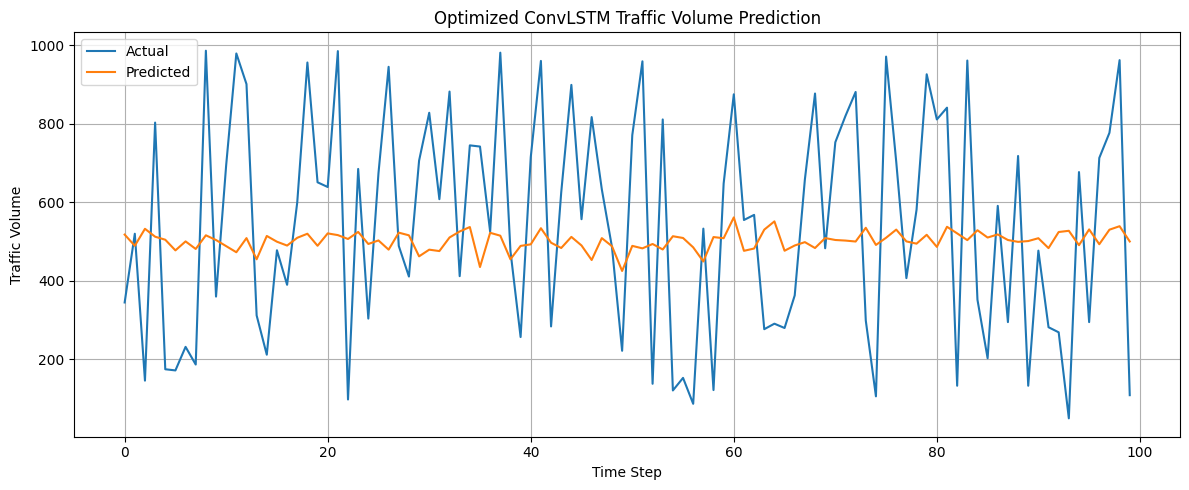

In [7]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:100], label='Actual')
plt.plot(y_pred_inv[:100], label='Predicted')
plt.title("Optimized ConvLSTM Traffic Volume Prediction")
plt.xlabel("Time Step")
plt.ylabel("Traffic Volume")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()